In [1]:
import shutil 
import time 
import pickle
import sys
import os
import random
from collections import defaultdict
import pdb
import numpy as np
import gymnasium_robotics 
import gymnasium as gym 
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

EXPLORATION_ACTIONS = {UP: (0, 1), DOWN: (0, -1), LEFT: (-1, 0), RIGHT: (1, 0)}

In [8]:
def cell_xy_to_rowcol(maze, xy_pos: np.ndarray) -> np.ndarray:
    """Converts a cell x and y coordinates to `(i,j)`"""

    i = np.reshape((maze.y_map_center - xy_pos[:, 1]) / maze.maze_size_scaling, (-1, 1))
    j = np.reshape((xy_pos[:, 0] + maze.x_map_center) / maze.maze_size_scaling, (-1, 1))

    return np.concatenate([i,j], axis=-1)

In [3]:
class QIteration:
    """Solves for optimal policy with Q-Value Iteration.

    Inspired by https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/pointmaze/q_iteration.py
    """
    def __init__(self, maze):
        self.maze = maze
        self.num_states = maze.map_length * maze.map_width
        self.num_actions = len(EXPLORATION_ACTIONS.keys())
        self.rew_matrix = np.zeros((self.num_states, self.num_actions))
        self.compute_transition_matrix()

    def generate_path(self, current_cell, goal_cell):
        self.compute_reward_matrix(goal_cell)
        q_values = self.get_q_values()
        current_state = self.cell_to_state(current_cell)
        waypoints = {}
        while True:
            action_id = np.argmax(q_values[current_state])
            next_state, _ = self.get_next_state(current_state, EXPLORATION_ACTIONS[action_id])
            current_cell = self.state_to_cell(current_state)
            waypoints[current_cell] = self.state_to_cell(next_state)
            if waypoints[current_cell] == goal_cell:
                break

            current_state = next_state

        return waypoints

    def reward_function(self, desired_cell, current_cell):
        if desired_cell == current_cell:
            return 1.0
        else:
            return 0.0

    def state_to_cell(self, state):
        i = int(state/self.maze.map_width)
        j = state % self.maze.map_width
        return (i, j)

    def cell_to_state(self, cell):
        return cell[0] * self.maze.map_width + cell[1]

    def get_q_values(self, num_itrs=50, discount=0.99):
        q_fn = np.zeros((self.num_states, self.num_actions))
        for _ in range(num_itrs):
            v_fn = np.max(q_fn, axis=1)
            q_fn = self.rew_matrix + discount*self.transition_matrix.dot(v_fn)
        return q_fn

    def compute_reward_matrix(self, goal_cell):
        for state in range(self.num_states):
            for action in range(self.num_actions):
                next_state, _ = self.get_next_state(state, EXPLORATION_ACTIONS[action])
                next_cell = self.state_to_cell(next_state)
                self.rew_matrix[state, action] = self.reward_function(goal_cell, next_cell)

    def compute_transition_matrix(self):
        """Constructs this environment's transition matrix.
        Returns:
          A dS x dA x dS array where the entry transition_matrix[s, a, ns]
          corresponds to the probability of transitioning into state ns after taking
          action a from state s.
        """
        self.transition_matrix = np.zeros((self.num_states, self.num_actions, self.num_states))
        for state in range(self.num_states):
            for action_idx, action in EXPLORATION_ACTIONS.items():
                next_state, valid = self.get_next_state(state, action)
                if valid:
                    self.transition_matrix[state, action_idx, next_state] = 1

    def get_next_state(self, state, action):
        cell = self.state_to_cell(state)

        next_cell = tuple(map(lambda i, j: int(i + j), cell, action))
        next_state = self.cell_to_state(next_cell)

        return next_state, self._check_valid_cell(next_cell)

    def _check_valid_cell(self, cell):
        # Out of map bounds
        if cell[0] >= self.maze.map_length:
            return False
        elif cell[1] >= self.maze.map_width:
            return False
        # Wall collision
        elif self.maze.maze_map[cell[0]][cell[1]] == 1:
            return False
        else:
            return True

In [4]:
class WaypointController:
    """Agent controller to follow waypoints in the maze.

    Inspired by https://github.com/Farama-Foundation/D4RL/blob/master/d4rl/pointmaze/waypoint_controller.py
    """
    def __init__(self, maze, gains={"p": 10.0, "d": -1.0}, waypoint_threshold=0.1):
        self.global_target_xy = np.empty(2)
        self.maze = maze

        self.maze_solver = QIteration(maze=self.maze)

        self.gains = gains
        self.waypoint_threshold = waypoint_threshold
        self.waypoint_targets = None

    def compute_action(self, obs):
        # Check if we need to generate new waypoint path due to change in global target
        if np.linalg.norm(self.global_target_xy - obs["desired_goal"]) > 1e-3 or self.waypoint_targets is None:
            # Convert xy to cell id
            achieved_goal_cell = tuple(self.maze.cell_xy_to_rowcol(obs["achieved_goal"]))
            self.global_target_id = tuple(self.maze.cell_xy_to_rowcol(obs["desired_goal"]))
            self.global_target_xy = obs["desired_goal"]

            self.waypoint_targets = self.maze_solver.generate_path(achieved_goal_cell, self.global_target_id)

            # Check if the waypoint dictionary is empty
            # If empty then the ball is already in the target cell location
            if self.waypoint_targets:
                self.current_control_target_id = self.waypoint_targets[achieved_goal_cell]
                self.current_control_target_xy = self.maze.cell_rowcol_to_xy(np.array(self.current_control_target_id))
            else:
                self.waypoint_targets[self.current_control_target_id] = self.current_control_target_id
                self.current_control_target_id = self.global_target_id
                self.current_control_target_xy = self.global_target_xy

        # Check if we need to go to the next waypoint
        dist = np.linalg.norm(self.current_control_target_xy - obs["achieved_goal"])
        if dist <= self.waypoint_threshold and self.current_control_target_id != self.global_target_id:
            self.current_control_target_id = self.waypoint_targets[self.current_control_target_id]
            # If target is global goal go directly to goal position
            if self.current_control_target_id == self.global_target_id:
                self.current_control_target_xy = self.global_target_xy
            else:
                self.current_control_target_xy = self.maze.cell_rowcol_to_xy(np.array(self.current_control_target_id)) - np.random.uniform(size=(2,))*0.2

        action = self.gains["p"] * (self.current_control_target_xy - obs["achieved_goal"]) + self.gains["d"] * obs["observation"][2:]
        action = np.clip(action, -1, 1)

        return action

In [46]:
def get_start_state_goal_pairs(dataset_name):
    if dataset_name == "pointmaze-large-sl":
        train_start_state_goal = [
            {"goal_cells": np.array([ [5,4], [1,10], [7,10] ], dtype=np.int32),
            "reset_cells": np.array([ [7,1] ], dtype=np.int32),
            },
        ]
    
    elif dataset_name == "pointmaze-xxlarge-v0":
        train_start_state_goal = [
            {"goal_cells": np.array([ [1,1], [1,2], [1,3], [1,4], [2,1], [2,4], [3,1], [3,1], [3,2], [3,3], [3,4], [3,5], [3,6] ], dtype=np.int32),
            "reset_cells": np.array([ [1,1], [1,2], [1,3], [1,4], [2,1], [2,4], [3,1], [3,1], [3,2], [3,3], [3,4], [3,5], [3,6] ], dtype=np.int32),
            },
            {"goal_cells": np.array([ [2,1], [3,1], [4,1], [5,1], [5,2], [6,2], [7,1], [7,2], [8,1], [8,2], [9,1], [9,2], [8,3], [9,3] ], dtype=np.int32),
            "reset_cells": np.array([ [2,1], [3,1], [4,1], [5,1], [5,2], [6,2], [7,1], [7,2], [8,1], [8,2], [9,1], [9,2], [8,3], [9,3] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [1,6], [1,7], [1,8], [1,9], [1,10], [1,11], [1,12], [2,6],[2,8], [2,11], [2,12], [3,5], [3,6], [3,8], [3,9], [3,10], [3,11], [3,12], [4,6], [4,11], [4,12], [5,6], [5,7], [5,8], [5,9], [5,10], [5,11], [5,12]], dtype=np.int32),
            "reset_cells": np.array([ [1,6], [1,7], [1,8], [1,9], [1,10], [1,11], [1,12], [2,6],[2,8], [2,11], [2,12], [3,5], [3,6], [3,8], [3,9], [3,10], [3,11], [3,12], [4,6], [4,11], [4,12], [5,6], [5,7], [5,8], [5,9], [5,10], [5,11], [5,12]], dtype=np.int32),
            },
            {"goal_cells": np.array([ [4,6], [5,6], [6,6], [7,6], [7,5], [7,4], [6,4], [5,4], [8,3], [8,4], [8,5], [8,6], [9,3], [9,4], [9,5], [9,6] ], dtype=np.int32),
            "reset_cells": np.array([ [4,6], [5,6], [6,6], [7,6], [7,5], [7,4], [6,4], [5,4], [8,3], [8,4], [8,5], [8,6], [9,3], [9,4], [9,5], [9,6] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [5,12], [5,11], [5,10], [5,9], [5,8], [6,8], [7,8], [7,9], [7,10], [7,11], [7,12], [8,8], [8,9], [8,11], [8,12], [9,8], [9,9], [9,11], [9,12]], dtype=np.int32),
            "reset_cells": np.array([ [5,12], [5,11], [5,10], [5,9], [5,8], [6,8], [7,8], [7,9], [7,10], [7,11], [7,12], [8,8], [8,9], [8,11], [8,12], [9,8], [9,9], [9,11], [9,12] ], dtype=np.int32),
            },            
          
            {"goal_cells": np.array([ [1,22], [1,21], [1,20], [1,19], [2,22], [2,19], [3,22], [3,22], [3,21], [3,20], [3,19], [3,18], [3,17] ], dtype=np.int32),
            "reset_cells": np.array([ [1,22], [1,21], [1,20], [1,19], [2,22], [2,19], [3,22], [3,22], [3,21], [3,20], [3,19], [3,18], [3,17] ], dtype=np.int32),
            },
            {"goal_cells": np.array([ [2,22], [3,22], [4,22], [5,22], [5,21], [6,21], [7,22], [7,21], [8,22], [8,21], [8,20], [9,22], [9,21], [9,20] ], dtype=np.int32),
            "reset_cells": np.array([ [2,22], [3,22], [4,22], [5,22], [5,21], [6,21], [7,22], [7,21], [8,22], [8,21], [8,20], [9,22], [9,21], [9,20] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [1,11], [1,12], [1,13], [1,14], [1,15], [1,16], [1,17], [2,11], [2,12], [2,15],[2,17], [3,11], [3,12], [3,13], [3,14], [3,15], [3,17], [3,18],[4,11], [4,12],[4,17], [5,11], [5,12], [5,13],[5,14], [5,15], [5,16], [5,17]], dtype=np.int32),
            "reset_cells": np.array([ [1,11], [1,12], [1,13], [1,14], [1,15], [1,16], [1,17], [2,11], [2,12], [2,15],[2,17], [3,11], [3,12], [3,13], [3,14], [3,15], [3,17], [3,18],[4,11], [4,12],[4,17], [5,11], [5,12], [5,13],[5,14], [5,15], [5,16], [5,17]], dtype=np.int32),
            },
            {"goal_cells": np.array([ [4,17], [5,17], [6,17], [7,17], [7,18], [7,19], [6,19], [5,19], [8,20], [8,19], [8,18], [8,17], [9,20], [9,19], [9,18], [9,17] ], dtype=np.int32),
            "reset_cells": np.array([ [4,17], [5,17], [6,17], [7,17], [7,18], [7,19], [6,19], [5,19], [8,20], [8,19], [8,18], [8,17], [9,20], [9,19], [9,18], [9,17] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [5,11], [5,12], [5,13], [5,14], [5,15], [6,15], [7,15], [7,14], [7,13], [7,12], [7,11], [8,15], [8,14], [8,12], [8,11], [9,15], [9,14], [9,12], [9,11] ], dtype=np.int32),
            "reset_cells": np.array([ [5,11], [5,12], [5,13], [5,14], [5,15], [6,15], [7,15], [7,14], [7,13], [7,12], [7,11], [8,15], [8,14], [8,12], [8,11], [9,15], [9,14], [9,12], [9,11] ], dtype=np.int32),
            },  
            
            {"goal_cells": np.array([ [16,1], [16,2], [16,3], [16,4], [15,1], [15,4], [14,1], [14,1], [14,2], [14,3], [14,4], [14,5], [14,6] ], dtype=np.int32),
            "reset_cells": np.array([ [16,1], [16,2], [16,3], [16,4], [15,1], [15,4], [14,1], [14,1], [14,2], [14,3], [14,4], [14,5], [14,6]], dtype=np.int32),
            },
            {"goal_cells": np.array([ [15,1], [14,1], [13,1], [12,1], [12,2], [11,2], [10,1], [10,2], [9,1], [9,2], [8,1], [8,2], [8,3], [9,3] ], dtype=np.int32),
            "reset_cells": np.array([ [15,1], [14,1], [13,1], [12,1], [12,2], [11,2], [10,1], [10,2], [9,1], [9,2], [8,1], [8,2], [8,3], [9,3]  ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [16,6], [16,7], [16,8], [16,9], [16,10], [16,11], [16,12], [15,6],[15,8], [15,11], [15,12], [14,5], [14,6], [14,8], [14,9], [14,10], [14,11], [14,12], [13,6], [13,11], [13,12], [12,6], [12,7], [12,8], [12,9], [12,10], [12,11], [12,12]], dtype=np.int32),
            "reset_cells": np.array([ [16,6], [16,7], [16,8], [16,9], [16,10], [16,11], [16,12], [15,6],[15,8], [15,11], [15,12], [14,5], [14,6], [14,8], [14,9], [14,10], [14,11], [14,12], [13,6], [13,11], [13,12], [12,6], [12,7], [12,8], [12,9], [12,10], [12,11], [12,12]], dtype=np.int32),
            },
          
            {"goal_cells": np.array([ [13,6], [12,6], [11,6], [10,6], [10,5], [10,4], [11,4], [12,4], [9,3], [9,4], [9,5], [9,6], [8,3], [8,4], [8,5], [8,6] ], dtype=np.int32),
            "reset_cells": np.array([ [13,6], [12,6], [11,6], [10,6], [10,5], [10,4], [11,4], [12,4], [9,3], [9,4], [9,5], [9,6], [9,3], [8,4], [8,5], [8,6] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [12,12], [12,11], [12,10], [12,9], [12,8], [11,8], [10,8], [10,9], [10,10], [10,11], [10,12], [9,8], [9,9], [9,11], [9,12], [8,8], [8,9], [8,11], [8,12] ], dtype=np.int32),
            "reset_cells": np.array([ [12,12], [12,11], [12,10], [12,9], [12,8], [11,8], [10,8], [10,9], [10,10], [10,11], [10,12], [9,8], [9,9], [9,11], [9,12], [8,8], [8,9], [8,11], [8,12] ], dtype=np.int32),
            },            
          
            {"goal_cells": np.array([ [15,22], [16,22], [16,21], [16,20], [16,19], [15,22], [15,19], [14,22],[14,22], [14,21], [14,20], [14,19], [14,18], [14,17] ], dtype=np.int32),
            "reset_cells": np.array([ [15,22], [16,22], [16,21], [16,20], [16,19], [15,22], [15,19], [14,22],[14,22], [14,21], [14,20], [14,19], [14,18], [14,17] ], dtype=np.int32),
            },
            {"goal_cells": np.array([ [14,22], [13,22], [12,22], [12,21], [11,21], [10,22], [10,21], [9,22], [9,21], [9,20], [8,22], [8,21], [8,20] ], dtype=np.int32),
            "reset_cells": np.array([ [14,22], [13,22], [12,22], [12,21], [11,21], [10,22], [10,21], [9,22], [9,21], [9,20], [8,22], [8,21], [8,20]  ], dtype=np.int32),
            },
          
            {"goal_cells": np.array([ [16,17], [16,16], [16,15], [16,14], [16,13], [16,12], [16,11], [15,17],[15,15], [15,12], [15,11], [14,18], [14,17], [14,15], [14,14], [14,13], [14,12], [14,11], [13,17], [13,12], [13,11], [12,17], [12,16], [12,15], [12,14], [12,13], [12,12], [12,11]], dtype=np.int32),
            "reset_cells": np.array([ [16,17], [16,16], [16,15], [16,14], [16,13], [16,12], [16,11], [15,17],[15,15], [15,12], [15,11], [14,18], [14,17], [14,15], [14,14], [14,13], [14,12], [14,11], [13,17], [13,12], [13,11], [12,17], [12,16], [12,15], [12,14], [12,13], [12,12], [12,11]], dtype=np.int32),
            },

          
            {"goal_cells": np.array([ [13,17], [12,17], [11,17], [10,17], [10,18], [10,19], [11,19], [12,19], [9,20], [9,19], [9,18], [9,17], [8,20], [8,19], [8,18], [8,17] ], dtype=np.int32),
            "reset_cells": np.array([ [13,17], [12,17], [11,17], [10,17], [10,18], [10,19], [11,19], [12,19], [9,20], [9,19], [9,18], [9,17], [8,20], [8,19], [8,18], [8,17] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [12,11], [12,12], [12,13], [12,14], [12,15], [11,15], [10,15], [10,14], [10,13], [10,12], [10,11], [9,15], [9,14], [9,12], [9,11], [8,15], [8,14], [8,12], [8,11] ], dtype=np.int32),
            "reset_cells": np.array([ [12,11], [12,12], [12,13], [12,14], [12,15], [11,15], [10,15], [10,14], [10,13], [10,12], [10,11], [9,15], [9,14], [9,12], [9,11], [8,15], [8,14], [8,12], [8,11]], dtype=np.int32),
            },     
          
        ]
        
    elif dataset_name == "pointmaze-large-v0":
        train_start_state_goal = [
            {"goal_cells": np.array([ [1,1], [1,2], [1,3], [1,4], [2,1], [2,4], [3,1] ], dtype=np.int32),
            "reset_cells": np.array([ [1,1], [1,2], [1,3], [1,4], [2,1], [2,4], [3,1] ], dtype=np.int32),
            },
            {"goal_cells": np.array([ [3,1], [3,2], [3,3], [3,4], [3,5], [3,6]], dtype=np.int32),
            "reset_cells": np.array([ [3,1], [3,2], [3,3], [3,4], [3,5], [3,6]], dtype=np.int32),
            },
            {"goal_cells": np.array([ [3,1], [4,1], [5,1], [5,2], [6,2], [7,1], [7,2] ], dtype=np.int32),
            "reset_cells": np.array([ [3,1], [4,1], [5,1], [5,2], [6,2], [7,1], [7,2] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [1,6], [2,6], [3,6], [4,6], [5,6], [5,7], [5,8]], dtype=np.int32),
            "reset_cells": np.array([ [1,6], [2,6], [3,6], [4,6], [5,6], [5,7], [5,8]], dtype=np.int32),
            },
            {"goal_cells": np.array([ [5,6], [6,6], [7,6], [7,5], [7,4], [6,4], [5,4] ], dtype=np.int32),
            "reset_cells": np.array([ [5,6], [6,6], [7,6], [7,5], [7,4], [6,4], [5,4] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [1,6], [1,7], [1,8], [1,9], [1,10], [2,10], [3,10]], dtype=np.int32),
            "reset_cells": np.array([ [1,6], [1,7], [1,8], [1,9], [1,10], [2,10], [3,10]], dtype=np.int32),
            },
            {"goal_cells": np.array([ [1,8], [2,8], [3,8], [3,9], [3,10], [4,10], [5,10]], dtype=np.int32),
            "reset_cells": np.array([ [1,8], [2,8], [3,8], [3,9], [3,10], [4,10], [5,10]], dtype=np.int32),
            },
            {"goal_cells": np.array([ [5,10], [5,9], [5,8], [6,8], [7,8], [7,9], [7,10] ], dtype=np.int32),
            "reset_cells": np.array([ [5,10], [5,9], [5,8], [6,8], [7,8], [7,9], [7,10] ], dtype=np.int32),
            },
        ]

    elif dataset_name == "pointmaze-medium-v0":
        train_start_state_goal = [
            {"goal_cells": np.array([ [6,5], [6,6], [5,6], [4,6] ], dtype=np.int32),
            "reset_cells": np.array([ [6,5], [6,6], [5,6], [4,6] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [4,1], [4,2], [5,1], [6,1], [6,2], [6,3], [5,3] ], dtype=np.int32),
            "reset_cells": np.array([ [4,1], [4,2], [5,1], [6,1], [6,2], [6,3], [5,3] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [1,5], [1,6], [2,4], [2,5], [2,6] ], dtype=np.int32),
            "reset_cells": np.array([ [1,5], [1,6], [2,4], [2,5], [2,6] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [1,1], [1,2], [2,1], [2,2], [3,2], [3,3] ], dtype=np.int32),
            "reset_cells": np.array([ [1,1], [1,2], [2,1], [2,2], [3,2], [3,3] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [5,3], [5,4], [4,2], [4,4], [4,5], [4,6], [3,3], [3,4], [2,4] ], dtype=np.int32),
            "reset_cells": np.array([ [5,3], [5,4], [4,2], [4,4], [4,5], [4,6], [3,3], [3,4], [2,4] ], dtype=np.int32),
            },
        ]

    elif dataset_name == "pointmaze-umaze-v0":
        train_start_state_goal = [
            {"goal_cells": np.array([ [1,1], [1,2], [1,3] ], dtype=np.int32),
            "reset_cells": np.array([ [1,1], [1,2], [1,3] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [3,1], [3,2], [3,3] ], dtype=np.int32),
            "reset_cells": np.array([ [3,1], [3,2], [3,3] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [1,3], [2,3] ], dtype=np.int32),
            "reset_cells": np.array([ [1,3], [2,3] ], dtype=np.int32),
            },

            {"goal_cells": np.array([ [3,3], [2,3] ], dtype=np.int32),
            "reset_cells": np.array([ [3,3], [2,3] ], dtype=np.int32),
            },
        ]

    else:
        raise NotImplementedError
    
    return train_start_state_goal

In [6]:
def collect_short_dataset(dataset_name, num_data):
    # if os.path.isfile("data/"+dataset_name+'-'+str(num_data)+".pkl"):
    #     print("A dataset with the same name already exists. Doing nothing. Delete the file if you want any changes.")
    #     exit()

    if "pointmaze-umaze" in dataset_name:
        env_name = "PointMaze_UMaze-v3"
    elif "pointmaze-medium" in dataset_name:
        env_name = "PointMaze_Medium-v3"
    elif "pointmaze-large" in dataset_name:
        env_name = "PointMaze_Large-v3"
    elif "pointmaze-xxlarge" in dataset_name:
        env_name = "PointMaze_XXLarge-v3"
    else:
        raise NotImplementedError
    
    # environment initialisation
    env = gym.make(env_name, continuing_task=False, max_episode_steps=10 * num_data)#, render_mode="human")
 
    # data placeholders
    observation_data = {
        "episode_id": np.zeros(shape=(int(num_data),), dtype=np.int32),
        "observation" : np.zeros(shape=(int(num_data), *env.observation_space["observation"].shape), dtype=np.float32),
        "achieved_goal" : np.zeros(shape=(int(num_data), *env.observation_space["achieved_goal"].shape), dtype=np.float32),
        "desired_goal" : np.zeros(shape=(int(num_data), *env.observation_space["desired_goal"].shape), dtype=np.float32),
    }
    action_data = np.zeros(shape=(int(num_data), *env.action_space.shape), dtype=np.float32)
    termination_data = np.zeros(shape = (int(num_data),), dtype=bool)

    # controller initialisation
    waypoint_controller = WaypointController(maze=env.unwrapped.maze)

    # get data collecting start state and goal pairs
    train_start_state_goal = get_start_state_goal_pairs(dataset_name)

    terminated = False
    truncated = False
    data_idx = 0
    episode_idx = 0
    success_count = 0

    num_dc = len(train_start_state_goal)

    dc_idx = episode_idx % num_dc
    sg_dict = train_start_state_goal[ dc_idx ]
    cell_dist = 0
    while cell_dist < 5:
    
        x,_ = sg_dict["goal_cells"].shape
        id = np.random.choice(x, size=1)[0]
        goal_cell = sg_dict["goal_cells"][id]
        
        x,_ = sg_dict["reset_cells"].shape
        id = np.random.choice(x, size=1)[0]
        reset_cell = sg_dict["reset_cells"][id]
        
        cell_dist = np.sum(np.abs(goal_cell - reset_cell))
        
    sg_dict["goal_cell"] = goal_cell
    sg_dict["reset_cell"] = reset_cell
    
    obs, _ = env.reset(options=sg_dict)

    while data_idx < int(num_data)-1:
        action = waypoint_controller.compute_action(obs)
        # Add some noise to each step action
        action += np.random.randn(*action.shape)*0.5
        action = np.clip(action, env.action_space.low, env.action_space.high, dtype=np.float32)

        observation_data["episode_id"][data_idx] = episode_idx
        observation_data["observation"][data_idx] = obs["observation"]
        observation_data["achieved_goal"][data_idx] = obs["achieved_goal"]
        observation_data["desired_goal"][data_idx] = obs["desired_goal"]
        action_data[data_idx] = action
        termination_data[data_idx] = terminated or truncated
        data_idx += 1

        obs, _, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            if info['success']:
                success_count += 1

                observation_data["episode_id"][data_idx] = episode_idx
                observation_data["observation"][data_idx] = obs["observation"]
                observation_data["achieved_goal"][data_idx] = obs["achieved_goal"]
                observation_data["desired_goal"][data_idx] = obs["desired_goal"]
                termination_data[data_idx] = terminated or truncated

                data_idx += 1
                episode_idx += 1
                episode_start_idx = data_idx
        
            else:
                data_idx = episode_start_idx
                print(f' === failed {episode_idx} ===')

            sg_dict = train_start_state_goal[ episode_idx % num_dc ]
            cell_dist = 0
            while cell_dist < 5:
            
                x,_ = sg_dict["goal_cells"].shape
                id = np.random.choice(x, size=1)[0]
                goal_cell = sg_dict["goal_cells"][id]
                
                x,_ = sg_dict["reset_cells"].shape
                id = np.random.choice(x, size=1)[0]
                reset_cell = sg_dict["reset_cells"][id]
                
                cell_dist = np.sum(np.abs(goal_cell - reset_cell))
            sg_dict["goal_cell"] = goal_cell
            sg_dict["reset_cell"] = reset_cell

            obs, _ = env.reset(options=sg_dict)

            terminated = False
            truncated = False
        
        if (data_idx + 1) % (num_data // 5) == 0:
            print("STEPS RECORDED:")
            print(data_idx)

            print("EPISODES RECORDED:")
            print(episode_idx)

            print("SUCCESS EPISODES RECORDED:")
            print(success_count)

    dataset = {"observations":observation_data, 
                "actions":action_data, 
                "terminations":termination_data,
                "success_count": success_count,
                "episode_count": episode_idx,
                }
    return dataset

In [25]:
def collect_long_dataset(dataset_name, num_data):
    # if os.path.isfile("data/"+dataset_name+'-'+str(num_data)+".pkl"):
    #     print("A dataset with the same name already exists. Doing nothing. Delete the file if you want any changes.")
    #     exit()

    if "pointmaze-umaze" in dataset_name:
        env_name = "PointMaze_UMaze-v3"
    elif "pointmaze-medium" in dataset_name:
        env_name = "PointMaze_Medium-v3"
    elif "pointmaze-large" in dataset_name:
        env_name = "PointMaze_Large-v3"
    elif "pointmaze-xxlarge" in dataset_name:
        env_name = "PointMaze_XXLarge-v3"
    else:
        raise NotImplementedError
    
    # environment initialisation
    env = gym.make(env_name, continuing_task=True, reset_target=True, max_episode_steps=10 * num_data)#, render_mode="human")
 
    # data placeholders
    observation_data = {
        "episode_id": np.zeros(shape=(int(num_data),), dtype=np.int32),
        "observation" : np.zeros(shape=(int(num_data), *env.observation_space["observation"].shape), dtype=np.float32),
        "achieved_goal" : np.zeros(shape=(int(num_data), *env.observation_space["achieved_goal"].shape), dtype=np.float32),
        "desired_goal" : np.zeros(shape=(int(num_data), *env.observation_space["desired_goal"].shape), dtype=np.float32),
    }
    action_data = np.zeros(shape=(int(num_data), *env.action_space.shape), dtype=np.float32)
    termination_data = np.zeros(shape = (int(num_data),), dtype=bool)
    reward_data = np.zeros(shape=(int(num_data),), dtype=np.uint8)

    # controller initialisation
    waypoint_controller = WaypointController(maze=env.unwrapped.maze)


    terminated = False
    truncated = False
    data_idx = 0
    episode_idx = 0
    success_count = 0


    obs, _ = env.reset()
    reward = 0

    while data_idx < int(num_data)-1:
        action = waypoint_controller.compute_action(obs)
        # Add some noise to each step action
        action += np.random.randn(*action.shape)*0.5
        action = np.clip(action, env.action_space.low, env.action_space.high, dtype=np.float32)

        observation_data["episode_id"][data_idx] = episode_idx
        observation_data["observation"][data_idx] = obs["observation"]
        observation_data["achieved_goal"][data_idx] = obs["achieved_goal"]
        observation_data["desired_goal"][data_idx] = obs["desired_goal"]
        action_data[data_idx] = action
        termination_data[data_idx] = terminated or truncated
        reward_data[data_idx] = reward
        data_idx += 1

        obs, reward, terminated, truncated, info = env.step(action)

        if reward:
            episode_idx += 1
            if info['success']:
                success_count += 1

        if (data_idx + 1) % (num_data // 5) == 0:
            print("STEPS RECORDED:")
            print(data_idx)

            print("EPISODES RECORDED:")
            print(episode_idx)

            print("SUCCESS EPISODES RECORDED:")
            print(success_count)

    dataset = {"observations":observation_data, 
                "actions":action_data, 
                "terminations":termination_data,
               "rewards": reward_data,
                "success_count": success_count,
                "episode_count": episode_idx,
                }
    return dataset

In [55]:
XXLARGE_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
    [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
    [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
]

In [59]:

continuing_task = False
env = gym.make("PointMaze_XXLarge-v3", continuing_task=continuing_task)
maze_map = np.array(env.unwrapped.maze._maze_map)
maze = env.unwrapped.maze
_background = maze_map == 1

(-0.5, 23.5, 17.5, -0.5)

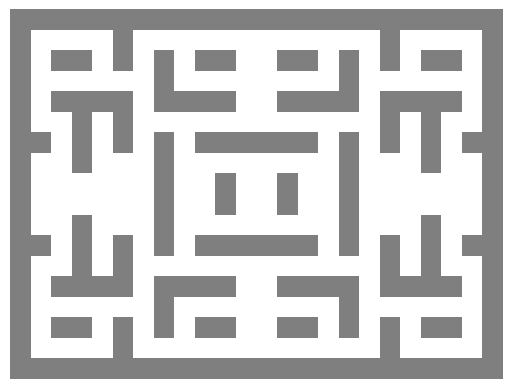

In [60]:
plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )

plt.axis('off')

In [49]:
dataset_name = 'pointmaze-xxlarge-v0'
goal_and_reset = get_start_state_goal_pairs(dataset_name)
num_dc = len(goal_and_reset)
print(f'total number of region in point_maze: {num_dc}')
dataset = collect_short_dataset(dataset_name, 1000000)

total number of region in point_maze: 20
STEPS RECORDED:
39999
EPISODES RECORDED:
228
SUCCESS EPISODES RECORDED:
228
STEPS RECORDED:
79999
EPISODES RECORDED:
461
SUCCESS EPISODES RECORDED:
461
STEPS RECORDED:
119999
EPISODES RECORDED:
692
SUCCESS EPISODES RECORDED:
692
STEPS RECORDED:
159999
EPISODES RECORDED:
927
SUCCESS EPISODES RECORDED:
927
STEPS RECORDED:
199999
EPISODES RECORDED:
1159
SUCCESS EPISODES RECORDED:
1159


In [75]:
with open('./pointmaze-xxlarge-v0-short.pkl', 'rb') as f:
  dataset = pickle.load(f)

In [76]:
trjs = []
N = dataset['terminations'].shape[0]
done = dataset['terminations']
s_idx = 0
for i in range(N):
    if done[i]:
        trj = dict()
        for k in dataset.keys():
            if k == 'observations':
                obs_dict = dict()
                for obs_k in dataset[k]:
                    obs_dict[obs_k] = dataset[k][obs_k][s_idx:i+1]
                trj[k] = obs_dict
            elif k not in ['success_count', 'episode_count']:
                trj[k] = dataset[k][s_idx:i+1]
                
        trjs.append(trj)
        s_idx = i+1

In [77]:
N

1000000

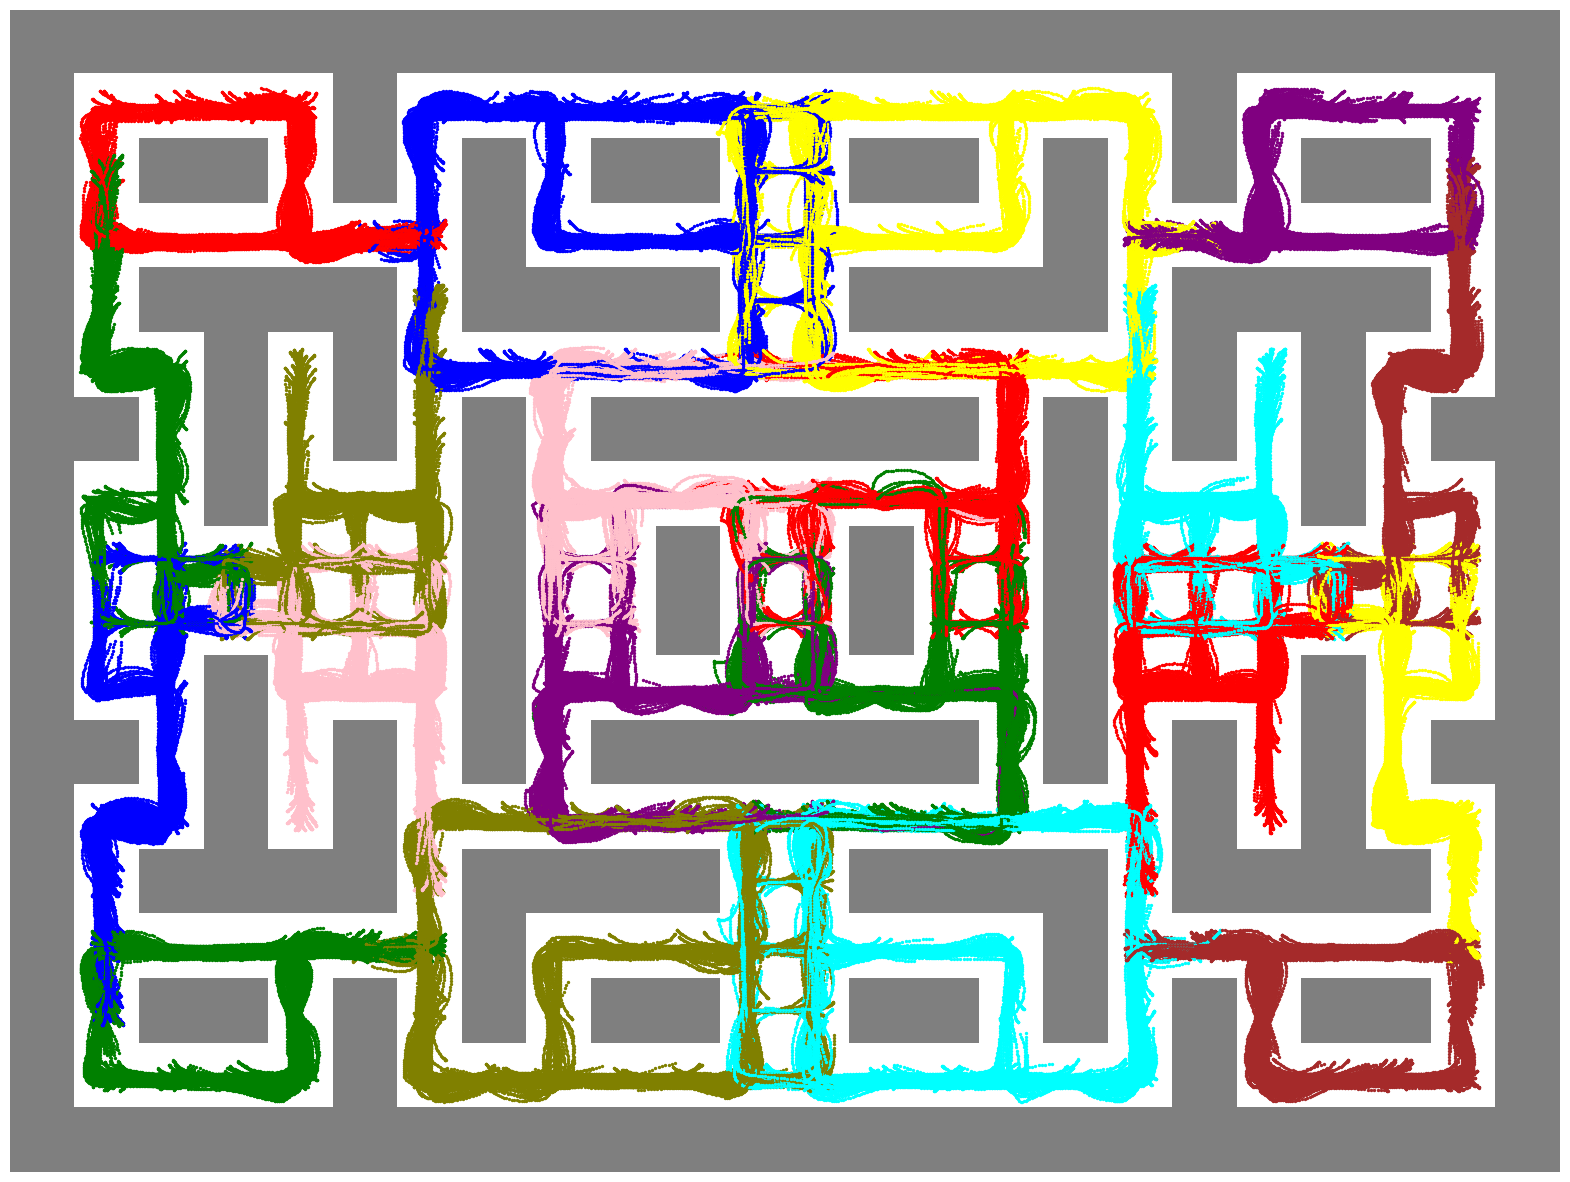

In [78]:

colors = [
  'red',
  'green',
  'blue',
  'olive',
  'pink',
  'purple',
  'brown',
  'yellow',
  'cyan',
]

plt.figure(figsize=(20,20))
plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )

for trj in trjs:
  obs = trj['observations']['observation'][:,:2]
  class_id = trj['observations']['episode_id'][0] % num_dc
  color_id = class_id % len(colors)
  
  path_length = obs.shape[0]
  ij = cell_xy_to_rowcol(maze, obs) -0.5
  plt.scatter(ij[:, 1], ij[:,0], s=2, c=colors[color_id], zorder=20)
  plt.axis('off')
  

(array([  1.,   6.,  48., 191., 216., 396., 470., 403., 336., 234., 264.,
        277., 248., 225., 164., 199., 169., 185., 219., 155., 192., 147.,
        115., 119.,  83., 111.,  77., 103.,  81.,  60.,  69.,  58.,  35.,
         44.,  21.,  11.,  12.,  13.,  15.,   5.,  14.,  15.,   7.,   7.,
          1.,   3.,   0.,   0.,   0.,   1.]),
 array([103. , 107.8, 112.6, 117.4, 122.2, 127. , 131.8, 136.6, 141.4,
        146.2, 151. , 155.8, 160.6, 165.4, 170.2, 175. , 179.8, 184.6,
        189.4, 194.2, 199. , 203.8, 208.6, 213.4, 218.2, 223. , 227.8,
        232.6, 237.4, 242.2, 247. , 251.8, 256.6, 261.4, 266.2, 271. ,
        275.8, 280.6, 285.4, 290.2, 295. , 299.8, 304.6, 309.4, 314.2,
        319. , 323.8, 328.6, 333.4, 338.2, 343. ]),
 <BarContainer object of 50 artists>)

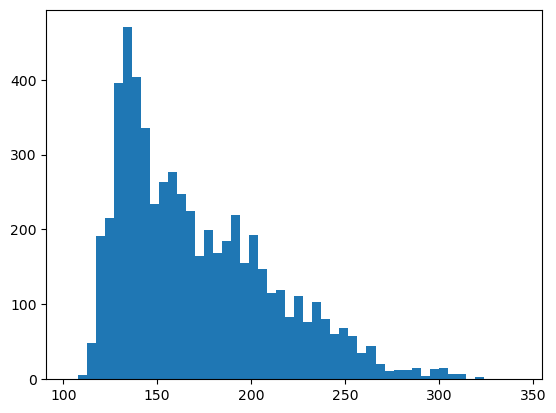

In [79]:
short_trj_len = np.array([t['observations']['observation'].shape[0] for t in trjs])
plt.hist(short_trj_len, bins=50)

In [26]:
dataset_name = 'pointmaze-xxlarge-v0'
dataset = collect_long_dataset(dataset_name, 100000)

STEPS RECORDED:
19999
EPISODES RECORDED:
54
SUCCESS EPISODES RECORDED:
54
STEPS RECORDED:
39999
EPISODES RECORDED:
104
SUCCESS EPISODES RECORDED:
104
STEPS RECORDED:
59999
EPISODES RECORDED:
153
SUCCESS EPISODES RECORDED:
153
STEPS RECORDED:
79999
EPISODES RECORDED:
202
SUCCESS EPISODES RECORDED:
202
STEPS RECORDED:
99999
EPISODES RECORDED:
257
SUCCESS EPISODES RECORDED:
257


In [22]:
trjs = []
N = dataset['terminations'].shape[0]
rewards = dataset['rewards']
s_idx = 0
for i in range(N):
    if rewards[i]:
        trj = dict()
        for k in dataset.keys():
            if k == 'observations':
                obs_dict = dict()
                for obs_k in dataset[k]:
                    obs_dict[obs_k] = dataset[k][obs_k][s_idx:i+1]
                trj[k] = obs_dict
            elif k not in ['success_count', 'episode_count']:
                trj[k] = dataset[k][s_idx:i+1]
                
        trjs.append(trj)
        s_idx = i+1

In [24]:
len(trjs)

249

(-0.5, 23.5, 17.5, -0.5)

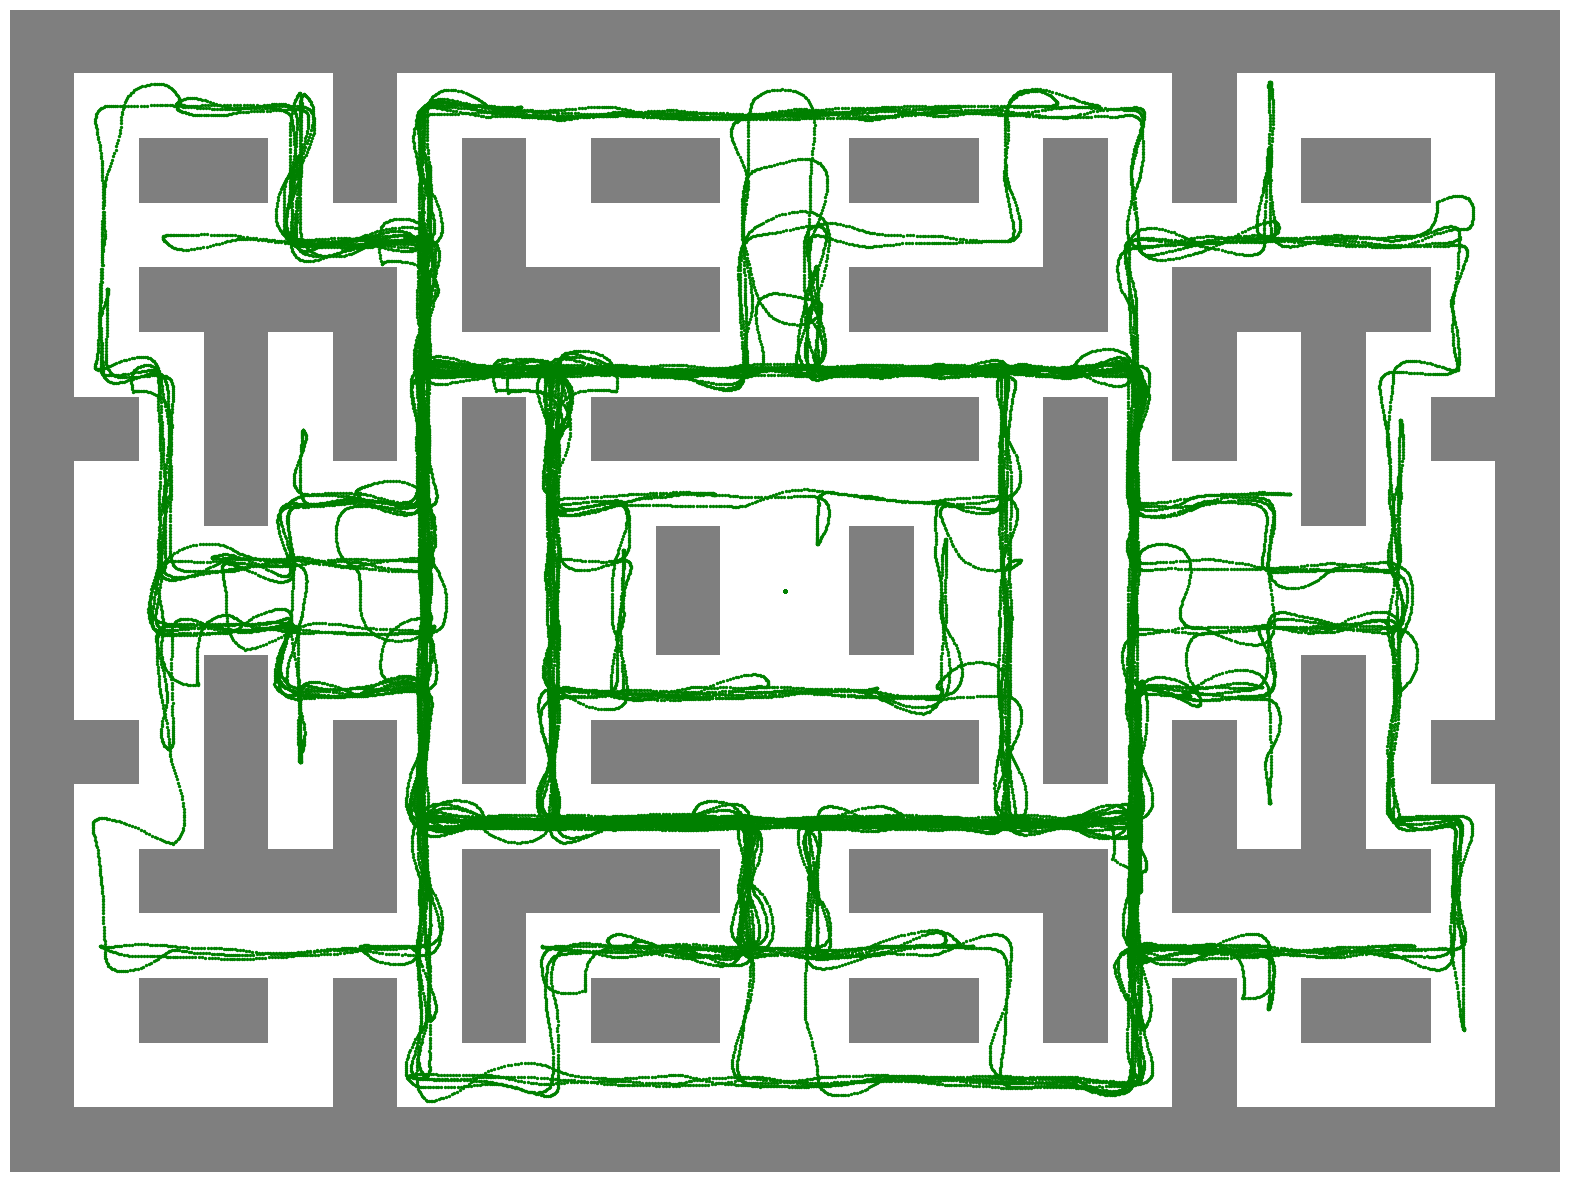

In [152]:
plt.figure(figsize=(20,20))
plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )

obs = dataset['observations']['observation'][:,:2]

path_length = obs.shape[0]
ij = cell_xy_to_rowcol(maze, obs) -0.5
plt.scatter(ij[:, 1], ij[:,0], s=2, c='green', zorder=20)
plt.axis('off')

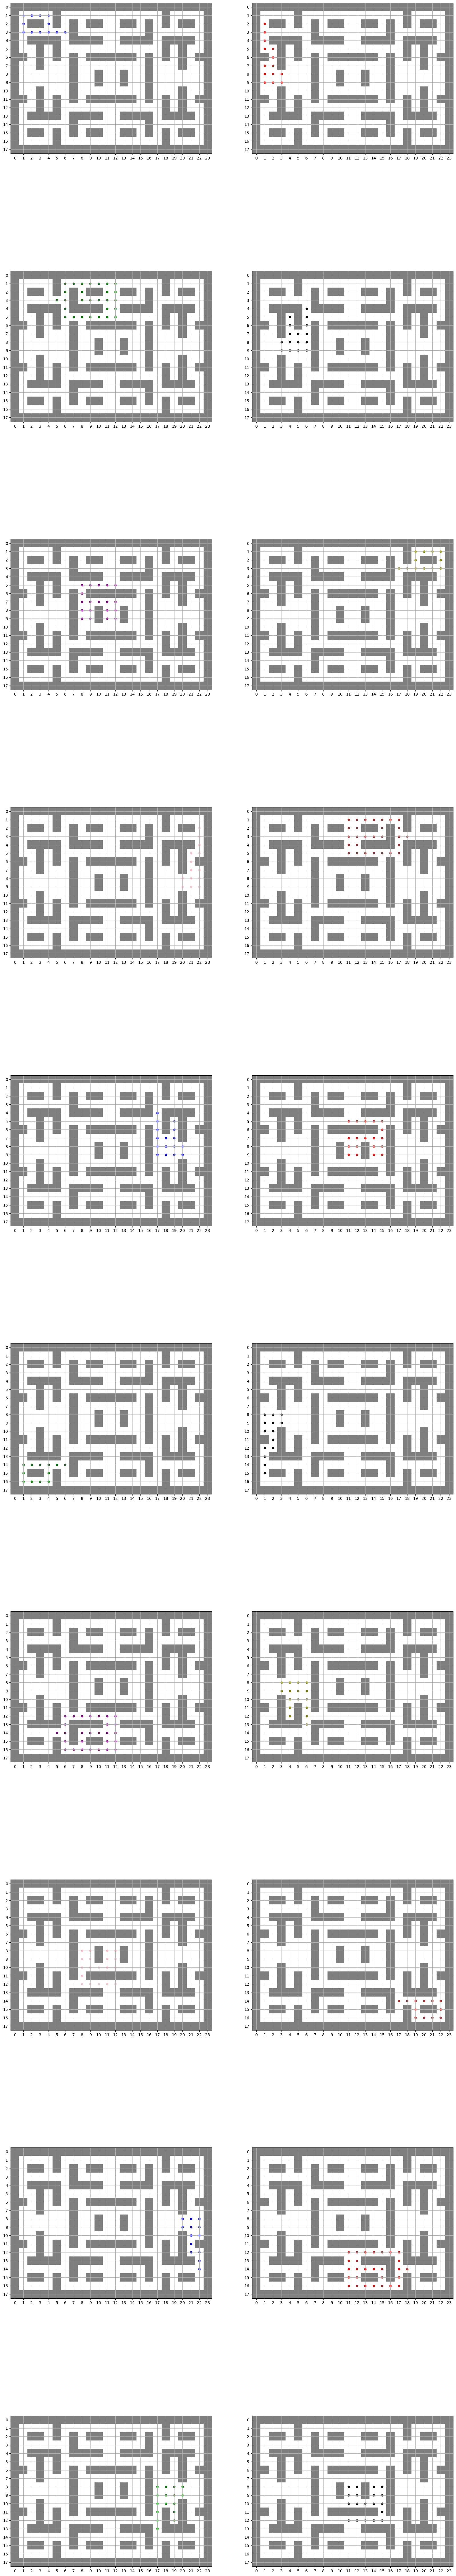

In [48]:
continuing_task = False
env = gym.make("PointMaze_XXLarge-v3", continuing_task=continuing_task)
maze_map = np.array(env.unwrapped.maze._maze_map)
maze = env.unwrapped.maze
_background = maze_map == 1


dataset_name = 'pointmaze-xxlarge-v0'
goal_and_reset = get_start_state_goal_pairs(dataset_name)

colors = [
  'blue',
  'red',
  'green',
  'black',
  'purple',
  'olive',
  'pink',
  'brown'
]

fig, axs = plt.subplots(10,2, figsize=(20,120))
for i in range(20):
  row = i // 2
  col = i % 2
  axs[row][col].imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )
  axs[row][col].set_xticks(np.arange(0,24,1))
  axs[row][col].set_yticks(np.arange(0,18,1))
  axs[row][col].grid(True)

for i, sg in enumerate(goal_and_reset):
  cells = sg['goal_cells']
  color = colors[i % len(colors)]
  
  row = i // 2
  col = i % 2
  for c in cells:
    axs[row][col].scatter(c[1], c[0], color=color, s=24)


In [17]:
_background.shape

(18, 24)

### Testing the optimal steps required to reach the furthest goal

In [66]:
env_name = "PointMaze_XXLarge-v3"
env = gym.make(env_name, continuing_task=False, reset_target=False, max_episode_steps=1600)

waypoint_controller = WaypointController(maze=env.unwrapped.maze)

sg_dict = {
  'goal_cell': np.array([16, 22], dtype=np.int32),
  'reset_cell': np.array([1, 1], dtype=np.int32)
}
num_eval = 10
steps = []
succ = 0
rollouts = []

for _ in range(num_eval):
    obs, _ = env.reset(options=sg_dict)
    rollout = [obs['observation']]
    done = False
    t = 0
    while not done:

        action = waypoint_controller.compute_action(obs)
        action = np.clip(action, env.action_space.low, env.action_space.high, dtype=np.float32)
        obs, reward, terminated, truncated, info = env.step(action)
        rollout.append(obs['observation'])
        t += 1
        done = terminated or truncated
        succ += info['success']
    steps.append(t)
    rollouts.append(rollout)
        

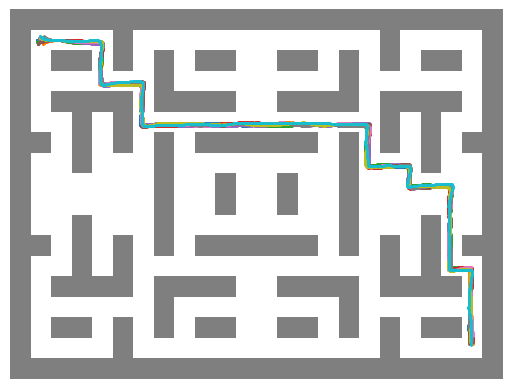

In [68]:
continuing_task = False
env = gym.make("PointMaze_XXLarge-v3", continuing_task=continuing_task)
maze_map = np.array(env.unwrapped.maze._maze_map)
maze = env.unwrapped.maze
_background = maze_map == 1

plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )

for r in rollouts:
  obs = np.array(r)[:, :2]
  path_length = obs.shape[0]
  ij = cell_xy_to_rowcol(maze, obs) -0.5
  plt.scatter(ij[:, 1], ij[:,0], s=1, zorder=20)
  plt.axis('off')
  

In [71]:
np.mean(steps)

946.7